In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install statannot

In [ ]:
! pip install pyensembl
! pip install mygene

     |████████████████████████████████| 61kB 3.7MB/s 
     |████████████████████████████████| 133kB 9.3MB/s 
  Created wheel for pyensembl: filename=pyensembl-1.9.1-cp37-none-any.whl size=56382 sha256=62d696ab0e336a21586625cec8091e9953fe1bd701c44614d9e890a02d084c83
  Stored in directory: /root/.cache/pip/wheels/93/50/8e/409570aa60efe5bac719b960ac880a6d1c42936439d3b4ffa9
  Created wheel for typechecks: filename=typechecks-0.1.0-cp37-none-any.whl size=2769 sha256=3a8df01e7ded094db9e091db2459b4dd65aa9dec920a6f27c7b8ae59b0966dbd
  Stored in directory: /root/.cache/pip/wheels/27/ad/82/4a9bbc88f1d31bb1a0c053e29efafc02f56e2ed1598f5639b2
  Created wheel for datacache: filename=datacache-1.1.5-cp37-none-any.whl size=16473 sha256=165721f8c2da63707fa9883db09d08fc29d2b4b948d7aace2495a15c8aab9204
  Stored in directory: /root/.cache/pip/wheels/6b/89/37/76d23043c61b5096dd0170fd6ea2f6474b38d69965b633118a
  Created wheel for memoized-property: filename=memoized_property-1.0.3-py2.py3-none-any.whl size=

In [3]:
import os
os.chdir('/content/drive/Shareddrives/CS229Buddies/project')

In [4]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import collections
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold, LeaveOneOut
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, f1_score, plot_precision_recall_curve
from scipy.stats import pearsonr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import operator
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
# import pyensembl

In [5]:
#Loading data and remove 
df = pd.read_csv('data/GSE113957_fpkm.txt', sep = '\t')
df = df.T
transcript_ids = list(df.loc['Transcript ID'])

df = df.drop(['Transcript ID', 'chr', 'start', 'end', 'strand', 'Length', 'Copies', 'Annotation/Divergence'], axis=0)
df['pids'] = [column.lower().split('_')[0] for column in df.index]
hgps = set(['139', '141', '197', '198', '199', '200', '201', '202', '203', '204'])
control_df = df[~df.pids.isin(hgps)]
hgps_df = df[df.pids.isin(hgps)]
control_df = control_df.drop(['pids'], axis = 1)
hgps_df = hgps_df.drop(['pids'], axis = 1)

control_df.columns = transcript_ids
hgps_df.columns = transcript_ids

total_df = control_df.append(hgps_df)

In [7]:
total_numpy = total_df.to_numpy()

In [ ]:
total_numpy.shape

(143, 27142)

In [6]:
labels = total_df.index
ages = [int(label.lower().split('_')[1].split('y')[0]) for label in labels]
sex = [int(label.lower().split('_')[2] == 'male') for label in labels]
race = [label.lower().split('_')[3] for label in labels]

In [ ]:
np.array(ages).max()

96

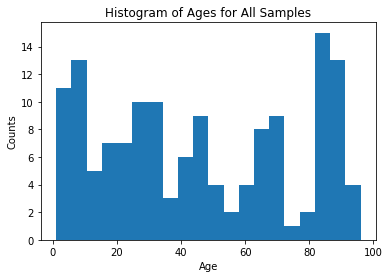

In [ ]:
plt.hist(ages, bins=20)
plt.title("Histogram of Ages for All Samples")
plt.xlabel('Age')
plt.ylabel('Counts')
plt.savefig('results/histogram_by_age.png')
#More of less uniform with some noise

In [ ]:
collections.Counter(sex) #1 is male, 0 is female

Counter({0: 44, 1: 99})

In [ ]:
collections.Counter(race)

Counter({'americanindian': 1,
         'asian': 2,
         'black': 8,
         'blackpuertorican': 1,
         'caucasian': 111,
         'caucasiansardinian': 1,
         'filipino': 1,
         'latinohispanic': 1,
         'unknown': 16,
         'whiteeastindian': 1})

In [ ]:
pca = PCA(n_components=2)
scaler = StandardScaler()
x = scaler.fit_transform(total_numpy)
principlecomponents = pca.fit_transform(x)
principledf = pd.DataFrame(principlecomponents)
principledf.columns = ['PC1', 'PC2']
principledf['age'] = ages
principledf['sex'] = sex

In [ ]:
maledf = principledf[principledf['sex'] == 1]
femaledf = principledf[principledf['sex'] == 0]

NameError: ignored

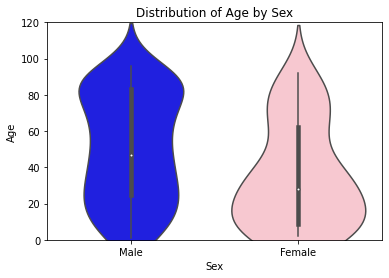

In [ ]:
male_age = list(maledf['age'])
female_age = list(femaledf['age'])
age_by_sex = {
    'Male': male_age,
    'Female': female_age
}
age_by_sex_df = pd.DataFrame.from_dict(age_by_sex, orient = 'index')

ax = sns.violinplot(data = age_by_sex_df.T, palette={'Male': 'blue', 'Female': 'pink'})
ax.set(xlabel = 'Sex', ylabel = 'Age', title = 'Distribution of Age by Sex', ylim=(0, 120))
statannot.add_stat_annotation(ax, data=age_by_sex_df.T, box_pairs = [('Male', 'Female')], test = 'Mann-Whitney', text_format = 'star', verbose = 2)
plt.savefig('results/violin_age_by_sex.png')

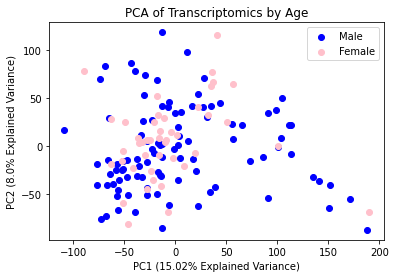

In [ ]:
plt.scatter(maledf['PC1'], maledf['PC2'], label = 'Male', c='blue')
plt.scatter(femaledf['PC1'], femaledf['PC2'], label = 'Female', c='pink')
plt.legend()
plt.title("PCA of Transcriptomics by Age")
plt.xlabel('PC1 (' + str(round(pca.explained_variance_ratio_[0]*100, 2)) + '% Explained Variance)')
plt.ylabel('PC2 (' + str(round(pca.explained_variance_ratio_[1]*100, 2)) + '% Explained Variance)')
plt.savefig('results/pca_by_sex.png')
#most of the older people are female

In [ ]:
principledf_withouthgps = principledf.iloc[:-10]
principledf_onlyhgps = principledf.iloc[-10:]

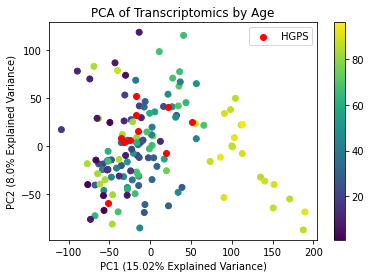

In [ ]:
plt.scatter(principledf_withouthgps['PC1'], principledf_withouthgps['PC2'], c=principledf_withouthgps['age'], cmap='viridis')
plt.colorbar()
plt.scatter(principledf_onlyhgps['PC1'], principledf_onlyhgps['PC2'], c='red', label = 'HGPS')
plt.title("PCA of Transcriptomics by Age")
plt.xlabel('PC1 (' + str(round(pca.explained_variance_ratio_[0]*100, 2)) + '% Explained Variance)')
plt.ylabel('PC2 (' + str(round(pca.explained_variance_ratio_[1]*100, 2)) + '% Explained Variance)')
plt.legend()
plt.savefig('results/pca_by_age.png')

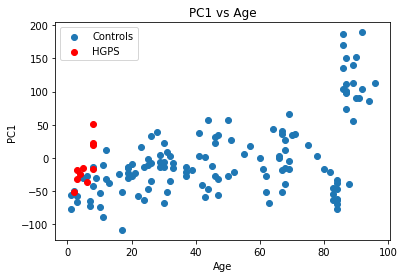

In [ ]:
plt.scatter(principledf_withouthgps['age'], principledf_withouthgps['PC1'], label = "Controls")
plt.scatter(principledf_onlyhgps['age'], principledf_onlyhgps['PC1'], c = 'red', label = "HGPS")
plt.xlabel('Age')
plt.ylabel('PC1')
plt.title("PC1 vs Age")
plt.legend()
plt.savefig('results/age_by_pc1.png')

In [9]:
def filter_genes(X_train, X_test):
  genes=[]
  for col in X_train.columns:
    vec=np.array(X_train[col])
    if vec.max()> 5 and vec.max()-vec.min()>5*vec.min():
      genes.append(col)
  return X_train[genes], X_test[genes]
  

In [7]:
X=control_df
X=X.reset_index()
X=X.drop(["index"], axis=1)
labels = list(control_df.index)
control_ages = [int(label.lower().split('_')[1].split('y')[0]) for label in labels]
y=np.array(control_ages)

In [ ]:
loo=LeaveOneOut()
X=control_df
X=X.reset_index()
X=X.drop(["index"], axis=1)
labels = list(control_df.index)
control_ages = [int(label.lower().split('_')[1].split('y')[0]) for label in labels]
y=np.array(control_ages)
n_genes=[]
y_pred=[]
y_act=[]
for train_index, test_index in loo.split(X):
  X_train, X_test = filter_genes(X.loc[train_index], X.loc[test_index])
  n_genes.append(X_train.shape[1])
  y_train, y_test = y[train_index], y[test_index]
  reg=LinearRegression().fit(X_train,y_train)
  y_pred.append(reg.predict(X_test))
  y_act.append(y_test)
y_pred = np.array([y[0] for y in y_pred])
y_act = np.array([y[0] for y in y_act])

R2: 0.762
p: 1.5519252596837256e-26


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(10, 90, '$R^2$=0.581')

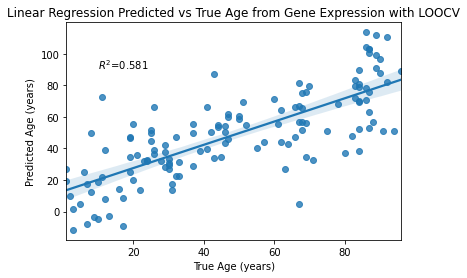

In [ ]:
sns.regplot(y_act,y_pred)
r2, p = pearsonr((y_act),(y_pred))
print("R2: " + str(round(r2, 3)))
print("p: " + str(p))
plt.xlabel('True Age (years)')
plt.ylabel('Predicted Age (years)')
plt.title("Linear Regression Predicted vs True Age from Gene Expression with LOOCV")
plt.text(10,90,s="$R^2$=" + str(round(r2**2, 3)))

In [8]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

In [14]:
control_df

,NM_173803,NM_014423,NM_001103167,NR_134623,NR_024490,NM_018397,NM_001037671,NR_106859,NM_133458,NM_001080424,NM_001271816,NR_027283,NR_073417,NR_033323,NM_001195545,NM_014879,NM_006918,NM_001145318,NR_109942,NR_135665,NM_001135914,NM_170679,NR_027000,NM_001318781,NM_004698,NM_017554,NM_015603,NR_136640,NM_002144,NR_102367,NM_001282763,NM_005663,NM_153213,NM_002559,NR_038194,NM_015902,NR_024111,NM_001042529,NM_001039569,NM_001025205,...,NR_038285,NM_207333,NM_001143760,NR_133006,NR_051989,NM_003525,NM_000160,NM_032487,NR_110936,NR_038990,NM_001079910,NR_110223,NM_138319,NM_024895,NR_134558,NM_004683,NM_001100408,NR_040535,NR_049865,NM_001318099,NM_012334,NM_145290,NM_006748,NR_033295,NR_030191,NM_001305457,NM_139285,NM_004332,NM_022495,NR_027141,NR_029666,NM_080390,NM_001177675,NR_125786,NM_001291993,NM_021923,NM_017417,NM_004354,NR_024278,NM_145282
101_19yr_Female_Caucasian,0.133,16.98,0.387,0,0.626,0.115,0,31.531,5.5,1.308,2.143,0.026,0,1.159,0,0,5.127,14.031,0,0.219,0.018,68.975,0.015,0.62,19.216,2.564,7.417,0,0,0.359,52.032,4.525,3.126,0,0,12.938,23.253,14.259,0.541,277.734,...,0.851,2.652,225.407,0,0,0,0,1.994,6.163,0.03,0,0,0.03,0.29,0.244,1.875,11.888,0.071,0,27.75,17.19,2.77,0,0,0,9.433,0.014,3.978,17.081,6.395,0,0,0,0,4.349,29.242,0.04,6.139,0.528,0
102_19yr_Male_Caucasian,0.213,16.772,0.168,0,0.701,0.077,0,27.992,6.473,1.357,1.952,0.029,0,1.487,0,0,3.701,13.255,0,0.28,0,61.827,0,0.211,11.628,1.296,7.865,0,0,0.494,36.853,3.693,3.514,0,0,11.535,28.562,11.706,0.202,284.64,...,1.203,2.613,205.338,0,0,0.219,0,2.873,4.459,0,0.018,0,0.022,0.441,0.091,2.624,12.583,0.147,0,21.449,18.545,4.02,0,0,0,6.454,0,3.378,14.215,7.04,0,0,0,0,5.642,31.561,0,5.603,1.1,0
103_19yr_Male_Caucasian,0.054,16.206,0.41,0,1.135,0.284,0,25.915,6.77,1.495,1.881,0,0,2.187,0.046,0,3.356,9.516,0,0.403,0.009,67.533,0,0.326,12.417,1.84,7.482,0,0,0.631,42.325,4.726,2.08,0,0,10.953,28.39,14.44,0.182,301.299,...,1.281,2.404,219.336,0.07,0,0,0,2.488,4.339,0,0.022,0,0.038,0.712,0.058,2.508,14.085,0.125,0,23.936,15.557,3.193,0,0,0,8.573,0,5.841,15.057,6.55,0,0.037,0,0,6.132,43.446,0,6.03,0.972,0
104_19yr_Male_Caucasian,0.066,15.345,0.148,0,0.685,0.304,0,18.776,5.773,1.688,1.927,0,0,1.89,0.056,0.039,2.455,9.884,0,0.306,0,62.057,0,0.503,12.878,1.867,8.941,0,0,0.476,31.844,5.389,3.217,0,0,11.372,25.176,13.423,0.183,315.602,...,1.237,1.996,183.929,0.084,0,0,0,3.15,4.482,0,0.018,0,0.034,0.573,0.374,2.339,14.824,0.26,0,29.59,15.571,3.297,0,0,0,8.485,0,2.237,14.247,5.598,0,0,0.022,0,3.752,39.371,0,5.048,1.461,0
105_20yr_Male_Caucasian,0.156,16.873,0.252,0.09,0.806,0.094,0,18.481,5.052,1.384,2.815,0,0,1.529,0,0,5.745,13.131,0,0.165,0.011,63.981,0,0.242,14.719,1.448,7.345,0,0,0.453,43.607,4.981,2.663,0,0,11.345,29.6,14.707,0.398,283.42,...,0.945,2.437,239.498,0.043,0,0,0,1.517,5.535,0,0.037,0,0.081,0.097,0.024,0.794,11.617,0.042,0,20.223,15.222,4.057,0,0,0,8.247,0,3.537,14.088,5.844,0,0.091,0,0,4.833,18.592,0,3.794,1.238,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94_12_male_Caucasian,0.214,16.103,0.323,0,1.042,0.086,0,27.271,4.877,1.369,2.212,0,0,1.393,0,0,2.828,15.166,0,0.196,0.011,68.21,0,0.34,12.354,1.515,8.76,0,0,0.484,38.405,4.744,2.753,0,0,11.523,28.661,10.25,0.213,296.9,...,0.842,1.594,220.301,0.138,0,0,0,2.155,5.181,0,0.02,0,0.012,0.208,0,2.613,14.377,0.119,0,25.277,10.419,2.737,0,0,0,7.695,0,2.666,14.963,6.893,0,0.049,0,0,4.494,28.903,0,6.531,0.947,0
95_13yr_Male_WhiTEEASTINDIAN,0.041,15.899,0.486,0,1.492,0.087,0,31.619,5.026,1.08,2.565,0,0,0.884,0,0,3.844,14.403,0,0.303,0.029,79.071,0.016,0.362,18.623,1.301,8.054,0,0,0.208,46.275,4.595,1.704,0,0,11.922,33.795,16.716,0.366,321.673,...,0.723,2.187,236.225,0,0,0.21,0,2.627,6.589,0,0.042,0,0.021,0.179,0,2.609,12.717,0.115,0,20.408,

In [10]:
feature_selection=SelectKBest(mutual_info_regression,k=int(500))
X_new=feature_selection.fit_transform(X.copy(), y)

In [17]:
reg=LinearRegression().fit(X_new,y)
features=pd.DataFrame([a,reg.coef_]).T.sort_values(by=1, ascending=False)
features=features.set_index(0)
features

,1
0,
NM_031992,0.849048
NM_006234,0.823749
NM_021626,0.7444
NM_002865,0.74364
NM_144717,0.736308
...,...
NM_205767,-0.636965
NM_025029,-0.649434
NM_175573,-0.735036


In [18]:
t=feature_selection.get_support()
a=[x[0] for x in zip(list(control_df.columns),list(t)) if x[1]]


In [34]:
def filter_genes(X_train):
  genes=[]
  for col in X_train.columns:
    vec=np.array(X_train[col])
    if vec.max()> 5 and vec.max()-vec.min()>5*vec.min():
      genes.append(col)
  return X_train[genes]
  

In [37]:
r=[]
loo=LeaveOneOut()
X=control_df
X=X.reset_index()
X=X.drop(["index"], axis=1)
labels = list(control_df.index)
control_ages = [int(label.lower().split('_')[1].split('y')[0]) for label in labels]
y=np.array(control_ages)
X_train = filter_genes(X)

# for j in np.linspace(500,600,20):
feature_selection=SelectKBest(mutual_info_regression,k=int(500))
X_new=feature_selection.fit_transform(X_train.copy(), y)
y_pred=[]
y_act=[]
# print(j)
for train_index, test_index in loo.split(X_new):
  X_train, X_test = X_new[train_index], X_new[test_index]
  # X_train, X_test = filter_genes(X_train, X_test)
  # n_genes.append(X_train.shape[1])
  y_train, y_test = y[train_index], y[test_index]
  reg=LinearRegression().fit(X_train,y_train)
  y_pred.append(reg.predict(X_test))
  y_act.append(y_test)
y_pred = np.array([y[0] for y in y_pred])
y_act = np.array([y[0] for y in y_act])
r2, p = pearsonr((y_act),(y_pred))
r.append(r2)

In [1]:
reg=LinearRegression().fit(X_train,y_train)

NameError: ignored

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(10, 90, '$R^2$=0.475')

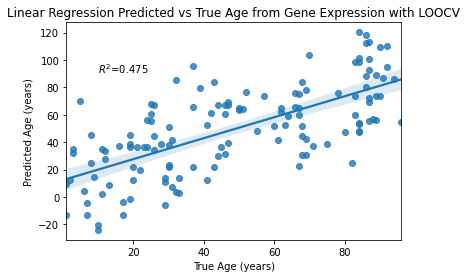

In [38]:
sns.regplot(y_act,y_pred)
r2, p = pearsonr((y_act),(y_pred))
# print("R2: " + str(round(r2, 3)))
# print("p: " + str(p))
plt.xlabel('True Age (years)')
plt.ylabel('Predicted Age (years)')
plt.title("Linear Regression Predicted vs True Age from Gene Expression with LOOCV")
plt.text(10,90,s="$R^2$=" + str(round(r2**2, 3)))

In [ ]:
# loo=LeaveOneOut()
# X=control_df
# X=X.reset_index()
# X=X.drop(["index"], axis=1)
# labels = list(control_df.index)
# control_ages = [int(label.lower().split('_')[1].split('y')[0]) for label in labels]
# y=np.array(control_ages)
# n_genes=[]
# y_pred_noint=[]
# y_act_noint=[]
# for train_index, test_index in loo.split(X):
#   X_train, X_test = filter_genes(X.loc[train_index], X.loc[test_index])
#   n_genes.append(X_train.shape[1])
#   y_train, y_test = y[train_index], y[test_index]
#   reg=LinearRegression(fit_intercept=False).fit(X_train,y_train)
#   y_pred_noint.append(reg.predict(X_test))
#   y_act_noint.append(y_test)


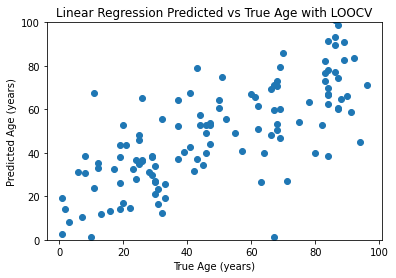

In [ ]:
# y_pred_noint = np.array([y[0] for y in y_pred_noint])
# y_act_noint = np.array([y[0] for y in y_act_noint])
# plt.scatter(y_act_noint,y_pred_noint)
# plt.ylim((0,100))
# plt.xlabel('True Age (years)')
# plt.ylabel('Predicted Age (years)')
# plt.title("Linear Regression Predicted vs True Age with LOOCV")
# plt.savefig('results/pred_true_age_linreg_noint.png')

In [ ]:
X["age"]=y_act



1.   List item
2.   List item



In [ ]:
X.to_csv("age_matrix.csv")

Output hidden; open in https://colab.research.google.com to view.

Text(0.5, 1.0, 'Linear Regression Predicted vs True Age with LOOCV')

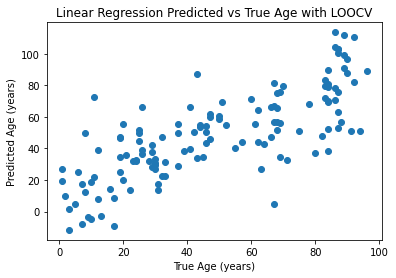

In [ ]:
plt.scatter(y_act,y_pred)
plt.xlabel('True Age (years)')
plt.ylabel('Predicted Age (years)')
plt.title("Linear Regression Predicted vs True Age with LOOCV")

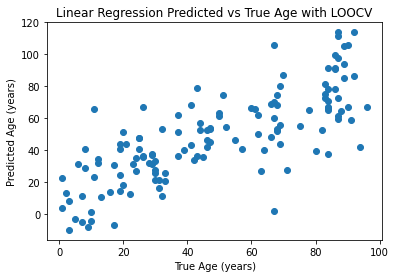

In [ ]:
plt.scatter(y_act,y_pred)
plt.xlabel('True Age (years)')
plt.ylabel('Predicted Age (years)')
plt.title("Linear Regression Predicted vs True Age with LOOCV")
plt.savefig('results/pred_true_age_linreg.png')

In [ ]:
np.median(np.abs(np.array(y_act)-np.array(y_pred)))

11.250212324401218

In [ ]:
r2, p = pearsonr(np.array(y_act),np.array(y_pred))
print("R2: " + str(round(r2, 3)))
print("p: " + str(p))

R2: 0.762
p: 1.5519252596837256e-26


In [ ]:
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
y = np.array([1, 1, 1, 2, 3, 3])
clf = LinearDiscriminantAnalysis()
clf.fit(X, y)
clf.predict([[4, 3]])

array([3])

In [ ]:
def make_labels(y,K):
  classifiers_ranges=get_ranges(y,K)
  y_mod=[]
  classifier_classes=np.zeros((K,len(y)))
  for i in range(K):
    for j in range(len(y)):
      for k in range(len(classifiers_ranges[i])):
        if y[j] in classifiers_ranges[i][k]:
          classifier_classes[i,j]=k
          break
  return classifier_classes, classifiers_ranges





In [ ]:
def get_ranges(y,K):
  classifiers_ranges=[]
  for i in range(K):
    classifier_ranges=[]
    classifier_ranges.append(list(range(0,i+1)))
    j=i+1
    while j<y.max():
      classifier_ranges.append(list(range(j,j+K+1)))
      j+=K+1
    classifiers_ranges.append(classifier_ranges)
  return classifiers_ranges

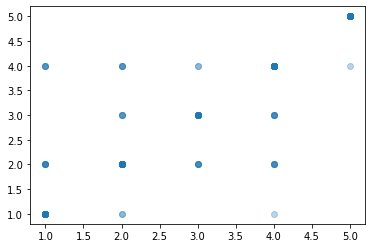

In [ ]:
plt.scatter(make_labels(y,20)[0],clf.predict(X), alpha=.3)

In [ ]:
def ensemble_voting(X_train,y_train,X_test,K):
  y_trans, classifiers_ranges=make_labels(y_train,K)
  y_pred_cat=[]
  for i in range(len(y_trans)):
    clf = LinearDiscriminantAnalysis()
    clf.fit(X_train, y_trans[i])
    y_pred_cat.extend(classifiers_ranges[i][int(clf.predict([X_test])[0])])
  d=dict(collections.Counter(y_pred_cat))
  return max(d.items(),key=operator.itemgetter(1))[0]

  


In [ ]:
def ensemble_voting_KNN(X_train,y_train,X_test,K):
  y_trans, classifiers_ranges=make_labels(y_train,K)
  y_pred_cat=[]
  for i in range(len(y_trans)):
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X_train, y_trans[i])
    y_pred_cat.extend(classifiers_ranges[i][int(clf.predict([X_test])[0])])
  d=dict(collections.Counter(y_pred_cat))
  return max(d.items(),key=operator.itemgetter(1))[0]


In [ ]:
ensemble_voting(X,y,X.iloc[-1],20)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11

12

In [ ]:
y[-1]

17

In [ ]:
def loocv(X, y, K):
  loo=LeaveOneOut()
  X=control_df
  X=X.reset_index()
  X=X.drop(["index"], axis=1)
  labels = list(control_df.index)
  control_ages = [int(label.lower().split('_')[1].split('y')[0]) for label in labels]
  y=np.array(control_ages)
  n_genes=[]
  y_pred=[]
  y_act=[]
  i=0
  for train_index, test_index in loo.split(X):
    i+=1
    X_train, X_test = filter_genes(X.loc[train_index], X.loc[test_index])
    n_genes.append(X_train.shape[1])
    y_train, y_test = y[train_index], y[test_index]
    y_pred.append(ensemble_voting(X_train,y_train,X_test.iloc[0],K))
    y_act.append(y_test[0])
    print(i,y_pred[-1],y_test[0])
  return y_pred, y_act

In [ ]:
def loocv_KNN(X, y, K):
  loo=LeaveOneOut()
  X=control_df
  X=X.reset_index()
  X=X.drop(["index"], axis=1)
  labels = list(control_df.index)
  control_ages = [int(label.lower().split('_')[1].split('y')[0]) for label in labels]
  y=np.array(control_ages)
  n_genes=[]
  y_pred=[]
  y_act=[]
  i=0
  for train_index, test_index in loo.split(X):
    i+=1
    X_train, X_test = filter_genes(X.loc[train_index], X.loc[test_index])
    n_genes.append(X_train.shape[1])
    y_train, y_test = y[train_index], y[test_index]
    y_pred.append(ensemble_voting_KNN(X_train,y_train,X_test.iloc[0],K))
    y_act.append(y_test[0])
    print(i,y_pred[-1],y_test[0])
  return y_pred, y_act

In [ ]:
y_pred_KNN, y_act_KNN=loocv_KNN(X,y,20)

1 13 19
2 19 19
3 24 19
4 24 19
5 29 20
6 43 20
7 24 31
8 19 31
9 16 32
10 0 32
11 19 33
12 29 33
13 41 37
14 19 37
15 0 37
16 10 39
17 46 51
18 78 52
19 19 55
20 71 57
21 19 60
22 64 71
23 25 75
24 10 78
25 37 80
26 87 94
27 87 89
28 89 87
29 89 90
30 90 89
31 87 86
32 89 92
33 90 87
34 1 1
35 61 12
36 0 22
37 24 25
38 24 29
39 25 24
40 37 23
41 70 26
42 16 21
43 50 24
44 5 67
45 29 67
46 26 68
47 12 82
48 24 66
49 10 68


KeyboardInterrupt: ignored

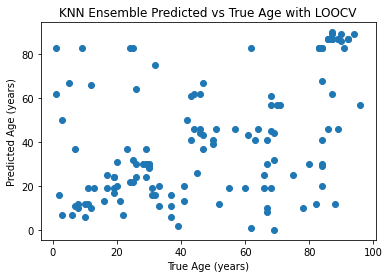

In [ ]:
plt.scatter(y_act_KNN,y_pred_KNN)
plt.xlabel('True Age (years)')
plt.ylabel('Predicted Age (years)')
plt.title("KNN Ensemble Predicted vs True Age with LOOCV")
plt.savefig('results/pred_true_age_ensemble_KNN.png')

In [ ]:
r2, p = pearsonr(np.array(y_act_KNN),np.array(y_pred_KNN))
print("R2: " + str(round(r2, 3)))
print("p: " + str(p))

R2: 0.482
p: 4.14526064958124e-09


In [ ]:
np.mean(np.abs(np.array(y_act_KNN)-np.array(y_pred_KNN)))

20.105263157894736

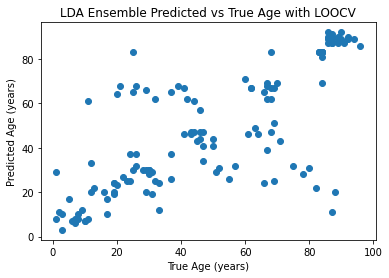

In [ ]:
plt.scatter(y_act,y_pred)
plt.xlabel('True Age (years)')
plt.ylabel('Predicted Age (years)')
plt.title("LDA Ensemble Predicted vs True Age with LOOCV")
plt.savefig('results/pred_true_age_ensemble_lda.png')

In [ ]:
r2, p = pearsonr(np.array(y_act),np.array(y_pred))
print("R2: " + str(round(r2, 3)))
print("p: " + str(p))

R2: 0.748
p: 4.8914686254984705e-25


In [ ]:
np.mean(np.abs(np.array(y_act)-np.array(y_pred)))

12.015037593984962